In [5]:
import os
import cv2
from matplotlib import pyplot as plt
import mediapipe as mp
import numpy as np
from math import *

In [6]:
from sklearn.model_selection import train_test_split # Scikit-learn for our evaluation metrics
from keras.utils.np_utils import to_categorical

# 02 MEDIAPIPE 

In [7]:
mp_face_mesh = mp.solutions.face_mesh              # FaceMesh Model has -- 478 -- Keypoints
mp_drawing_styles = mp.solutions.drawing_styles    # Drawing styles
mp_drawing = mp.solutions.drawing_utils

### Given the original image and obtaining the values through the model

In [8]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)   # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                     # Image is no longer writeable
    results = model.process(image)                    # Make prediction
    image.flags.writeable = True                      # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)    # COLOR CONVERSION RGB 2 BGR
    return image, results

### Storing the keypoints values in the mediapipe into a variables

In [9]:
# face bounder indices
FACE_OVAL=[ 10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103,67, 109]

# Left eyes indices
LEFT_EYE =[ 362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398 ]
LEFT_EYEBROW =[ 336, 296, 334, 293, 300, 276, 283, 282, 295, 285 ]

# right eyes indices
RIGHT_EYE=[ 33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246 ]
RIGHT_EYEBROW=[ 70, 63, 105, 66, 107, 55, 65, 52, 53, 46 ]

### Calculating blink rate (Euclidian distance)

In [10]:
# Blinking Ratio
def blinkRatio(img, landmarks, right_indices, left_indices):
    # Right eyes
    # horizontal line
    rh_right = landmarks[right_indices[0]]
    rh_left = landmarks[right_indices[8]]
    # vertical line
    rv_top = landmarks[right_indices[12]]
    rv_bottom = landmarks[right_indices[4]]
    # draw lines on right eyes
    # cv.line(img, rh_right, rh_left, utils.GREEN, 2)
    # cv.line(img, rv_top, rv_bottom, utils.WHITE, 2)

    # LEFT_EYE
    # horizontal line
    lh_right = landmarks[left_indices[0]]
    lh_left = landmarks[left_indices[8]]

    # vertical line
    lv_top = landmarks[left_indices[12]]
    lv_bottom = landmarks[left_indices[4]]

    rhDistance = euclaideanDistance(rh_right, rh_left)
    rvDistance = euclaideanDistance(rv_top, rv_bottom)

    lvDistance = euclaideanDistance(lv_top, lv_bottom)
    lhDistance = euclaideanDistance(lh_right, lh_left)

    reRatio = rhDistance/rvDistance
    leRatio = lhDistance/lvDistance

    ratio = (reRatio+leRatio)/2
    return ratio

# Euclaidean distance
def euclaideanDistance(point, point1):
    x, y = point
    x1, y1 = point1
    distance = sqrt((x1 - x)**2 + (y1 - y)**2)
    if 1> distance:
        return 1
    else:
        return distance

# 03 EXTRACT POSITION LENDMARKS (KEYPOINTS VALUES)

In [11]:
def extract_landmarks(img, results):
    frame = cv2.resize(image, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
    mesh_coords = mesh_coord_detection(img, results)

    # extract face 468 keyponits
    face = np.array([[res.x, res.y, res.z] for res in results.multi_face_landmarks[0].landmark]).flatten() if results.multi_face_landmarks[0] else np.zeros(478*3)

    # extract right-eye 16 keypoints
    right_eye_coords = np.array([mesh_coords[p] for p in RIGHT_EYE]).flatten()

    # extract left-eye 16 keypoints
    left_eye_coords = np.array([mesh_coords[p] for p in LEFT_EYE]).flatten()

    # calculating eye ratio
    ratio = np.array(blinkRatio(frame, mesh_coords, RIGHT_EYE, LEFT_EYE)).flatten()

    # return all feature values
    #return np.concatenate([face,right_eye_coords,left_eye_coords,ratio])
    return np.concatenate([face, ratio])


def mesh_coord_detection(img, results):
    if img is None:
        img_height, img_width= 0,0
    else:
        img_height, img_width= img.shape[:2]
    # list[(x,y), (x,y)....]
    mesh_coord = [(int(point.x * img_width), int(point.y * img_height)) for point in results.multi_face_landmarks[0].landmark] if results.multi_face_landmarks[0] else np.zeros(478 *2)

    # returning the list of tuples for each landmarks
    return mesh_coord

# 04 SETUP FOLDER FOR COLLECTION 

In [12]:
DATA_PATH = r'D:\Курсовая\truelie\ML_Data'
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)        # Path for exported data, numpy arrays
# C:\Users\Sms Studio\Desktop\University_Research_Projects\LieDetection\Semester Research Program\ML_Data
actions = np.array(['true', 'lie'])       # Actions that we try to detect

true_vdos = 156                       # for taking total true videos. 30,30 , 63,63, 50,25 , 25,50, 100,50 , 156,64

lie_vdos = 64                  # for taking total lie videos.

sequence_length = 30             # Videos are going to be 30 frames in length

In [13]:
# Create Folders for save keypoints values

for action in actions:
    if action == 'true':
        for sequence in range(true_vdos):
            try:
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
            except:
                pass
    else:
        for sequence in range(lie_vdos):
            try:
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
            except:
                pass

# 05 COLLECT KEYPOINTS VALUES FOR TRAINING AND TESTING

In [14]:
for action in actions:   # Loop through actions
    if action == 'true':
        for sequence in range(true_vdos):          # Loop through sequences (true videos)
            VDO_PATH = 'Datasets/' + action +'/' + str(sequence) + '/' + str(sequence) + '.mp4'  # /Datasets/true/0/0.mp4
            cap = cv2.VideoCapture(VDO_PATH)                # Read Video
            with mp.solutions.face_mesh.FaceMesh(                         # set mediapipe model
                max_num_faces =1,
                refine_landmarks = True,
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5) as face_mesh:
                for frame_num in range(sequence_length):

                    ret, frame = cap.read() # return status(boolean) , image                               # Read feed

                    print("Processing Video Path:",VDO_PATH)                      # Processing Video Path:Datasets/true/0/0.mp4

                    image, results = mediapipe_detection(frame, face_mesh)                # Make detection

                    feature_values = extract_landmarks(image,results)                   # Extract face , ratio

                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num)) # create export keypoints local path


                # Keypoints Shape:(1435,) ---> (1434 + 1)

#                   pd.DataFrame(face).to_csv(path)

                    np.save(npy_path, feature_values)                                   # Save Keypoints values

                cap.release()     # Release feed

                cv2.waitKey(1)    # wait for 1 Secound

                print("_____Finish_______")
    else:
        for sequence in range(lie_vdos):          # Loop through sequences (true videos)
            VDO_PATH = 'Datasets/' + action +'/' + str(sequence) + '/' + str(sequence) + '.mp4'  # /Datasets/lie/0/0.mp4
            cap = cv2.VideoCapture(VDO_PATH)                # Read Video
            with mp.solutions.face_mesh.FaceMesh(                         # set mediapipe model
                max_num_faces =1,
                refine_landmarks = True,
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5) as face_mesh:
                for frame_num in range(sequence_length):

                    ret, frame = cap.read()                                # Read feed

                    print("Processing Video Path:",VDO_PATH)                      # Processing Video Path:Datasets/lie/0/0.mp4

                    image, results = mediapipe_detection(frame, face_mesh)                # Make detection

                    feature_values = extract_landmarks(image,results)                   # Extract face keypoints

                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num)) # create export keypoints local path

                    # Keypoints Shape:(1405,) ---> (1404 + 1)

                    np.save(npy_path, feature_values)                                   # Save Keypoints values



                cap.release()     # Release feed

                cv2.waitKey(1)    # wait for 1 Secound

                print("_____Finish_______")

Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing Video Path: Datasets/true/0/0.mp4
Processing

# PREPROCESS DATA AND CREATE LABLES AND FEATURES

In [15]:
feature_values.shape

(1435,)

In [16]:
label_map = {label:num for num, label in enumerate(actions)}  # Actions Label Map  {'true': 0, 'lie': 1}

In [17]:
sequences, labels = [], []                 # like : Features(X) Data , labels(Y) Data
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []                            # Save all of diff.frames paricular sequence
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))   # load np array
            window.append(res)
            print('Processing Video : '+'Datasets/' + action +'/' + str(sequence) + '/' + str(sequence) + '.mp4')
        sequences.append(window)
        labels.append(label_map[action])

Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video : Datasets/true/0/0.mp4
Processing Video

Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/10/10.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/true/100/100.mp4
Processing Video : Datasets/

In [18]:
X = np.array(sequences)  # sequences
y = to_categorical(labels).astype(int)  # labels

# Train & Testing Partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [19]:
X.shape
#y.shape
#X_train.shape
#X_test.shape
#y_train.shape
#y_test.shape

(220, 30, 1435)

# 07 BUILD AND TRAIN LSTM MODELS

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [105]:
log_dir = os.path.join('Logs_new')
tb_callback = TensorBoard(log_dir=log_dir)

In [106]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1435)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [107]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [108]:
model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
6/6 [==============================] - 3s 47ms/step - loss: 4.8623 - categorical_accuracy: 0.3011
Epoch 2/50
6/6 [==============================] - 0s 47ms/step - loss: 1.1095 - categorical_accuracy: 0.5284
Epoch 3/50
6/6 [==============================] - 0s 44ms/step - loss: 2.0274 - categorical_accuracy: 0.5284
Epoch 4/50
6/6 [==============================] - 0s 47ms/step - loss: 3.3428 - categorical_accuracy: 0.6193
Epoch 5/50
6/6 [==============================] - 0s 48ms/step - loss: 3.0374 - categorical_accuracy: 0.5170
Epoch 6/50
6/6 [==============================] - 0s 48ms/step - loss: 2.3720 - categorical_accuracy: 0.6420
Epoch 7/50
6/6 [==============================] - 0s 47ms/step - loss: 3.9024 - categorical_accuracy: 0.5511
Epoch 8/50
6/6 [==============================] - 0s 47ms/step - loss: 4.8033 - categorical_accuracy: 0.5398
Epoch 9/50
6/6 [==============================] - 0s 47ms/step - loss: 8.0383 - categorical_accuracy: 0.6420
Epoch 10/50
6/6 [==

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            384000    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 538,530
Trainable params: 538,530
Non-trai

# MAKE PREDICTIONS

In [26]:
res = model.predict(X_test)

2/2 [==============================] - 0s 21ms/step


In [27]:
X_test.shape

(44, 30, 1435)

In [28]:
np.sum(res[0])

1.0

In [29]:
actions[np.argmax(res[2])]

'true'

In [30]:
y_test

array([[0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [31]:
actions[np.argmax(y_test[3])]

'lie'

# SAVE WEIGHTS

In [32]:
model.save('action2.h5')

# Evaluation using Confusion Matrix and Accuracy

In [33]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [34]:
yhat = model.predict(X_test)

2/2 [==============================] - 0s 20ms/step


In [35]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [36]:
ytrue

[1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [37]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[ 0, 11],
        [ 0, 33]],

       [[33,  0],
        [11,  0]]], dtype=int64)

In [38]:
accuracy_score(ytrue, yhat)

0.75

# Test in Real Time

In [39]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num].capitalize() + ' ' + str(int(prob*100)) + ' %', (3, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return output_frame

In [40]:
sequence = []
threshold = 0.5

cap = cv2.VideoCapture('riyasTrueVideo.mp4')
# Set mediapipe model
with mp.solutions.face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, face_mesh)
        print(results)

        # 2. Prediction logic
        keypoints = extract_landmarks(image , results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            print(np.array(sequence).shape)
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            image = prob_viz(res, actions, image, colors)
        
        # Show to screen
        cv2.imshow('Lie Detection', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [41]:
cap.release()
cv2.destroyAllWindows()

# SVM

In [69]:
X_train_avg = X_train.mean(axis=2)  # Усреднение данных по временным шагам
X_test_avg = X_test.mean(axis=2)

In [72]:
from sklearn.svm import SVC

svm_model = SVC()  # Создание модели SVM
svm_model.fit(X_train_avg, y_train[:, 0])  # Обучение модели на данных X_train_avg и метках классов y_train
svm_predictions = svm_model.predict(X_test_avg)

# KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()  # Создание модели KNeighborsClassifier
knn_model.fit(X_train_avg, y_train[:, 0])  # Обучение модели на данных X_train_avg и метках классов y_train
knn_predictions = knn_model.predict(X_test_avg)  # Предсказание на данных X_test_avg

In [74]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [75]:
svm_confusion = confusion_matrix(y_test[:, 0], svm_predictions)
svm_classification_rep = classification_report(y_test[:, 0], svm_predictions)
svm_accuracy = accuracy_score(y_test[:, 0], svm_predictions)

In [76]:
knn_confusion = confusion_matrix(y_test[:, 0], knn_predictions)
knn_classification_rep = classification_report(y_test[:, 0], knn_predictions)
knn_accuracy = accuracy_score(y_test[:, 0], knn_predictions)

In [78]:
print("Метрики SVM:")
print("Матрица ошибок:")
print(svm_confusion)
print("Отчет по классификации:")
print(svm_classification_rep)
print("Точность:", svm_accuracy)



Метрики SVM:
Матрица ошибок:
[[ 3  8]
 [ 4 29]]
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.78      0.88      0.83        33

    accuracy                           0.73        44
   macro avg       0.61      0.58      0.58        44
weighted avg       0.69      0.73      0.70        44

Точность: 0.7272727272727273


In [79]:
print("\nМетрики KNeighborsClassifier:")
print("Матрица ошибок:")
print(knn_confusion)
print("Отчет по классификации:")
print(knn_classification_rep)
print("Точность:", knn_accuracy)


Метрики KNeighborsClassifier:
Матрица ошибок:
[[ 4  7]
 [ 5 28]]
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.44      0.36      0.40        11
           1       0.80      0.85      0.82        33

    accuracy                           0.73        44
   macro avg       0.62      0.61      0.61        44
weighted avg       0.71      0.73      0.72        44

Точность: 0.7272727272727273


# DecisionTreeClassifier

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_avg, y_train[:, 0])

DecisionTreeClassifier()

In [82]:
dt_predictions = dt_model.predict(X_test_avg)

In [84]:
dt_confusion = confusion_matrix(y_test[:, 0], dt_predictions)
dt_classification_rep = classification_report(y_test[:, 0], dt_predictions)
dt_accuracy = accuracy_score(y_test[:, 0], dt_predictions)

print("Метрики Decision Tree:")
print("Матрица ошибок:")
print(dt_confusion)
print("Отчет по классификации:")
print(dt_classification_rep)
print("Точность:", dt_accuracy)

Метрики Decision Tree:
Матрица ошибок:
[[ 5  6]
 [ 9 24]]
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.36      0.45      0.40        11
           1       0.80      0.73      0.76        33

    accuracy                           0.66        44
   macro avg       0.58      0.59      0.58        44
weighted avg       0.69      0.66      0.67        44

Точность: 0.6590909090909091


# CNN

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [117]:
log_dir = os.path.join('Logs_CNN')
tb_callback = TensorBoard(log_dir=log_dir)

In [118]:
model_2 = Sequential()

# Добавление слоя свертки
model_2.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30,1435)))

# Добавление слоя подвыборки
model_2.add(MaxPooling1D(pool_size=2))

# Преобразование в одномерный вектор
model_2.add(Flatten())

# Полносвязный слой
model_2.add(Dense(64, activation='relu'))

# Выходной слой (предполагается, что у вас два класса)
model_2.add(Dense(1, activation='sigmoid'))

In [119]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [120]:
model_2.fit(X_train, y_train[:, 0], epochs=50, batch_size=32, validation_data=(X_test, y_test[:, 0]), callbacks=[tb_callback])
#model_cnn.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
6/6 [==============================] - 1s 56ms/step - loss: 0.9293 - accuracy: 0.6136 - val_loss: 0.5555 - val_accuracy: 0.7500
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 0.6910 - accuracy: 0.5966 - val_loss: 0.5620 - val_accuracy: 0.7500
Epoch 3/50
6/6 [==============================] - 0s 28ms/step - loss: 0.5822 - accuracy: 0.7330 - val_loss: 0.5495 - val_accuracy: 0.7500
Epoch 4/50
6/6 [==============================] - 0s 29ms/step - loss: 0.5601 - accuracy: 0.7045 - val_loss: 0.5786 - val_accuracy: 0.7500
Epoch 5/50
6/6 [==============================] - 0s 25ms/step - loss: 0.5394 - accuracy: 0.7557 - val_loss: 0.5442 - val_accuracy: 0.7500
Epoch 6/50
6/6 [==============================] - 0s 28ms/step - loss: 0.5283 - accuracy: 0.7216 - val_loss: 0.5501 - val_accuracy: 0.7500
Epoch 7/50
6/6 [==============================] - 0s 27ms/step - loss: 0.5146 - accuracy: 0.7273 - val_loss: 0.5507 - val_accuracy: 0.7727
Epoch 8/50
6/6 [===========

In [121]:
loss, accuracy = model_2.evaluate(X_test, y_test[:, 0])
print("Точность:", accuracy)

2/2 [==============================] - 0s 8ms/step - loss: 0.5291 - accuracy: 0.7955
Точность: 0.7954545617103577


In [129]:
yhat = model_2.predict(X_test)
yhat = np.argmax(yhat, axis=1).tolist()
cnn_report = classification_report(y_test[:,0], yhat)
print(cnn_report)

2/2 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.25      1.00      0.40        11
           1       0.00      0.00      0.00        33

    accuracy                           0.25        44
   macro avg       0.12      0.50      0.20        44
weighted avg       0.06      0.25      0.10        44



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
# import matplotlib.pyplot as plt

# # Обучение модели
# history = model_2.fit(X_train, y_train[:, 0], epochs=50, batch_size=32, validation_data=(X_test, y_test[:, 0]))

# # Получение истории потерь
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Построение графика
# plt.plot(range(1, len(train_loss) + 1), train_loss, label='Потери на обучающей выборке')
# plt.plot(range(1, len(val_loss) + 1), val_loss, label='Потери на валидационной выборке')
# plt.xlabel('Эпохи')
# plt.ylabel('Потери')
# plt.legend()
# plt.show()


#### 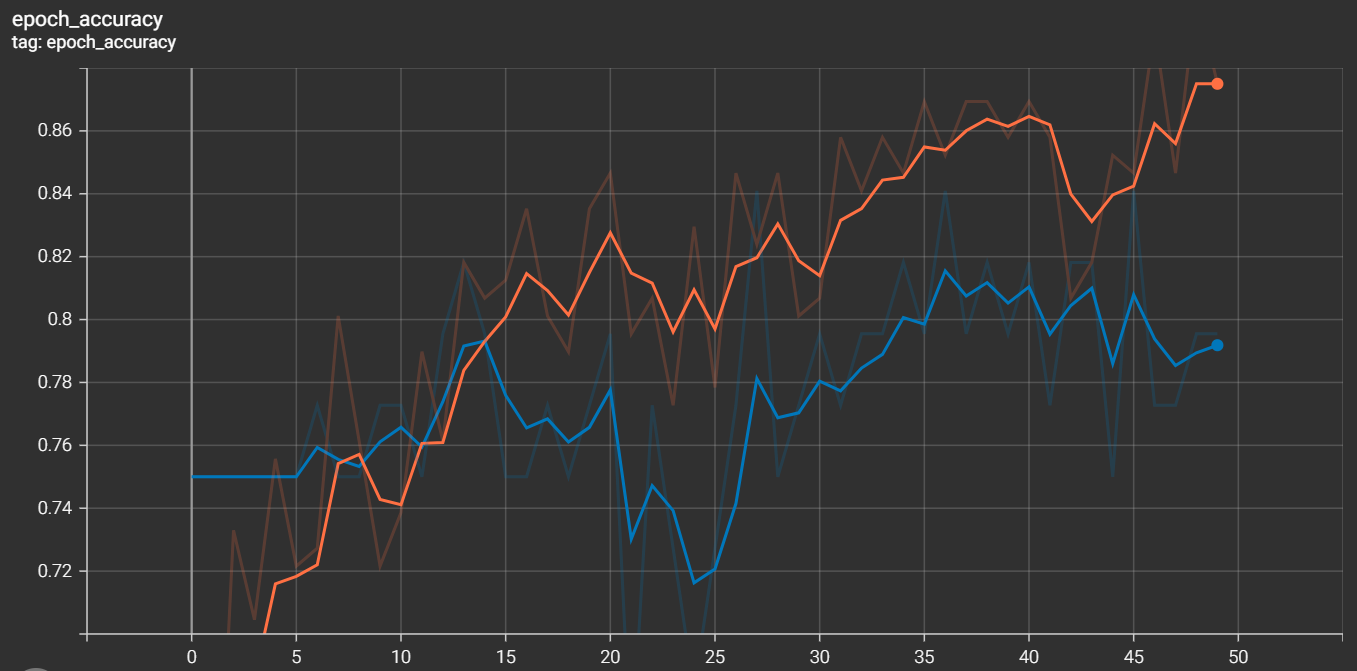

###### 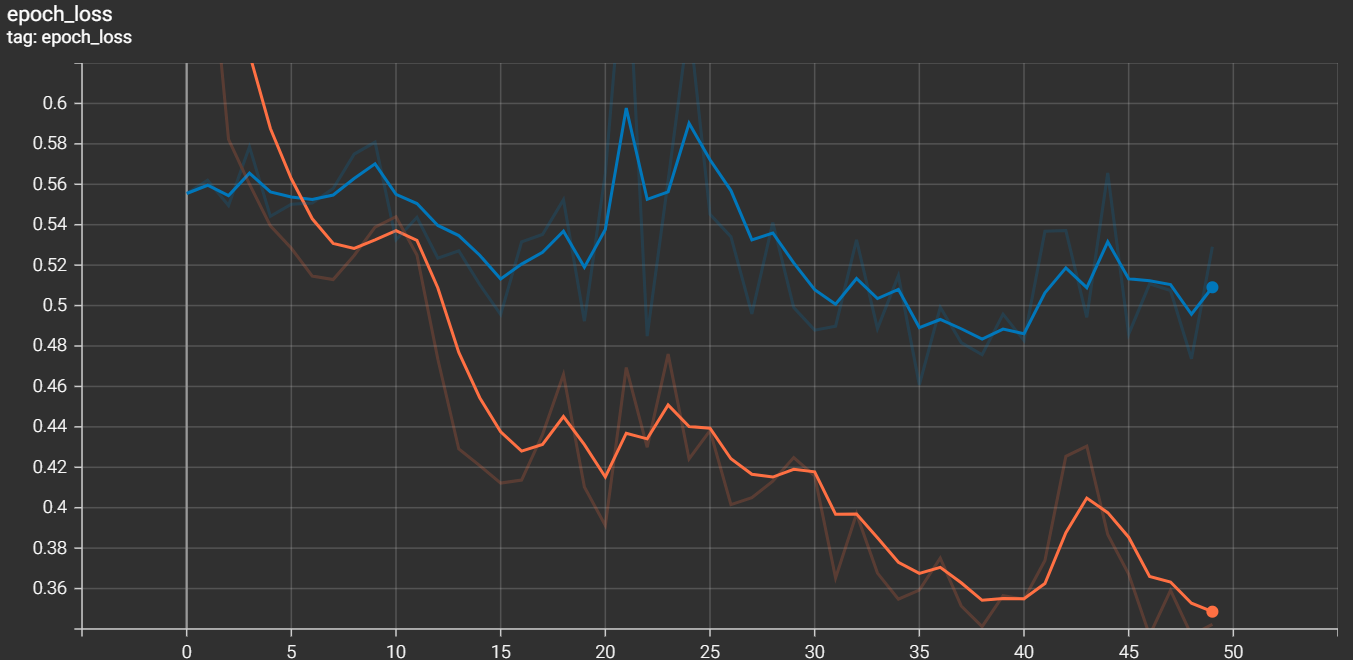